In [1]:
#libraries
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import csv
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import copy
import torch.optim as optim
# Assign device depending on the machine capabilities
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [2]:
# helpers
def construct_linear_pool_fixed(K, D):
    Id = torch.eye(K)
    for i in range (K):
        A = Id[i].repeat(D).view(-1, K)
        if i == 0:
            mat = A
        else:
            mat = torch.cat((mat, A), 0)      
    return mat.T

def construct_linear_in_fixed(K, D):
    return torch.eye(D).repeat(K, 1)

def forgy_initialization(X, K):
    
    N = X.shape[0]
    idx = np.random.choice(N, K)
    centers_init = X[idx]
    return centers_init

def normalize_data(X, verbose=False):
    """
    Normalize the data by subtracting the mean and dividing by the variance.
    Arguments:
        X: numpy array with the data.
        verbose: bool variable to print out sanity checks.

    Output: X normalized
    """
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)

    if verbose:
        print("Function: ", normalize_data.__name__)
        print("Mean: ", mean)
        print("Std: ", std)

    X = (X - mean) / std

    return X

def freeze_module (module):
    """
    :param module:
    :return:
    """
    for param in module.parameters():
        param.requires_grad = False

    return None

def unfreeze_module(module):
    """
    :param module:
    :return:
    """
    for param in module.parameters():
        param.requires_grad = True

    return None

Function:  normalize_data
Mean:  [502998.059  497112.7394]
Std:  [166620.11759907 173538.01530277]
Function:  normalize_data
Mean:  [505577.4        499794.46666667]
Std:  [158584.07946357 166557.82198859]
Shape X:  (5000, 2)
Shape centers:  (15, 2)
Shape labels:  (5000,)


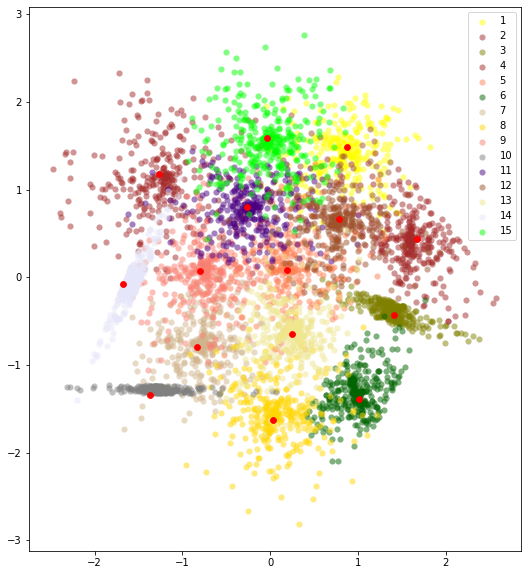

In [3]:
def Read_Two_Column_File(file_name):
    with open(file_name, 'r') as f_input:
        csv_input = csv.reader(f_input, delimiter=' ', skipinitialspace=True)
        x = []
        y = []
        for cols in csv_input:
            x.append(float(cols[0]))
            y.append(float(cols[1]))
        X = np.vstack((x, y))
    return X.T

def Read_One_Column_File(file_name):
    with open(file_name, 'r') as f_input:
        csv_input = csv.reader(f_input, delimiter=' ', skipinitialspace=True)
        labels = []
        for cols in csv_input:
            labels.append(float(cols[0]))
    return np.array(labels)

def scatter_plot(data, centers, labels):
    K = centers.shape[0]
    cdict = {1: 'yellow', 2: 'brown', 3: 'olive', 4:'brown', 5: 'coral',
             6: 'darkgreen', 7: 'tan', 8: 'gold', 9:'salmon', 10: 'gray', 
             11: 'indigo', 12: 'sienna', 13: 'khaki', 14:'lavender', 15: 'lime'}
    fig, ax = plt.subplots(figsize=(10, 10))
    for i in range(1, K+1):
        idx = np.where(labels == i)
        ax.scatter(X[idx, 0], X[idx, 1], c = cdict[i], label = i, linewidths = 0.1, alpha = 0.5)
    # plot centers
    ax.scatter(centers[:,0], centers[:,1], color = 'red', linewidths = 0.75, alpha = 1)
    ax.set_aspect('equal')
    ax.legend()
    plt.show()
    return None

X = Read_Two_Column_File('./data/clustering_basic_benchmark/s4.txt')
# normalize data
X = normalize_data(X , verbose = True)
centers_true = Read_Two_Column_File('./data/clustering_basic_benchmark/s4-cb.txt')
# normalize centers
centers_true = normalize_data(centers_true, verbose = True)
Y = Read_One_Column_File('./data/clustering_basic_benchmark/s4-label.txt')
# get the length of the data set
N = X.shape[0]
# compute the number of clusters
K = centers_true.shape[0]
# compute the dimension of the data set
D = X.shape[1]
print("Shape X: ", X.shape)
print("Shape centers: ", centers_true.shape)
print("Shape labels: ", Y.shape)
scatter_plot(X, centers_true, Y)

In [4]:
# class to handle the data set
class HandlerDataset(Dataset):
    """
    Class to handle the datasets.
    """
    def __init__(self, data, labels):
        """
        Initialization for the given data set.
        :param data: numpy array with the data.
        :param labels: labels of the data.
        """
        self.data = data
        self.labels = labels

    def __len__(self):
        """
        Gets the length of the data set.
        :return: length of the data set.
        """
        return (len(self.labels))

    def __getitem__(self, idx):
        """
        Gets the pair (x,y) given an index.
        :param idx: index to retrieve the data and label.
        :return:
            x: data
            y: label
        """
        x = torch.from_numpy(self.data[idx]).type(torch.FloatTensor)
        y = self.labels[idx]

        return x, y

In [5]:
# Neural network for k-means
class NeuralKmeans(nn.Module):
    def __init__(self, K, D, linear_in_fixed, linear_pool_fixed, b_init, alpha, beta):
        super(NeuralKmeans, self).__init__()
        self.K = K
        self.D = D
        self.alpha = alpha
        self.beta = beta
        self.linear_in = nn.Linear(D, K*D)
        self.linear_pool = nn.Linear(K*D, K, bias = False)
        with torch.no_grad():
            self.linear_in.weight.copy_(linear_in_fixed)
            self.linear_in.bias.copy_(b_init)
            self.linear_pool.weight.copy_(linear_pool_fixed)
            
        self.max_pool = nn.MaxPool1d(kernel_size = K, return_indices = True)
        
    def forward(self, x):
        # input linear layer
        #print ("Initial shape: ", x.shape)
        x = self.linear_in(x)
        # square activation
        x = torch.square(x)
        #print ("Shape after in and quadratic layer: ", x.shape)
        # pool linear layer
        x = self.linear_pool(x)
        #print ("Shape after linear pool layer: ", x.shape)
        x = torch.unsqueeze(x, 1)
        # make x negative to use the max pooling
        x = -1 * x
        x, idx = self.max_pool(x)
        # multiply by -1 to get back to positive values
        # and squeeze the tensors
        x = -1 * torch.squeeze(x)
        idx = torch.squeeze(idx)
        #print("Shape idx = ", idx.shape)
        #print("Shape x = ", x.shape)
        # get Nk from the unpooling
        Nk, _ = np.histogram(idx, bins = np.arange(self.K + 1))
        Nk = Nk.astype(float)
        Nk = torch.from_numpy(Nk)
        Nk += self.beta
        # group the output x given the indices from the maxpool layer
        gk = self.alpha * torch.ones_like(Nk, dtype=torch.float)
        gk = gk.scatter_add_(0, idx, x)
        #print("Shape gk = ", gk.shape)
        #print("Shape Nk = ", Nk.shape)
        #print("gk = ",gk.data)
        #print("Nk = ", Nk) 
        return gk, Nk
    
# loss function
def loss_function(gk, Nk):

    loss = (1/2) * torch.sum(gk/Nk)
    return loss


In [6]:
# construct the input linear layer as described in the paper
linear_in_fixed = construct_linear_in_fixed(K, D)
#print(linear_in_fixed)
# use Forgy initialization
centers_init = forgy_initialization(X, K)
centers_init_flattened = copy.deepcopy(centers_init)
print("Shape of centers_init before flatten: ", centers_init.shape)
#print(centers_init)
# reshape centers init so that can be assigned to b
centers_init_flattened = -1 * centers_init_flattened.ravel()
print("Shape of centers_init after flatten: ", centers_init_flattened.shape)
#print(centers_init_flattened)
# initialize the vector b with the Forgy initialization
b_init = torch.from_numpy(centers_init_flattened)
# construct the pool linear layer as described in the paper
linear_pool_fixed = construct_linear_pool_fixed(K, D)
#print(linear_pool_fixed)
print("Shape of linear_in_fixed: ", linear_in_fixed.shape)
print("Shape of linear_pool_fixed: ", linear_pool_fixed.shape)
#print(b_init)
NKmeans = NeuralKmeans(K, D, linear_in_fixed, linear_pool_fixed, b_init, 1e-6, 1e-6)
batch_size = N
train_dataset = HandlerDataset(data = X, labels = Y)
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
num_epochs = 64

Shape of centers_init before flatten:  (15, 2)
Shape of centers_init after flatten:  (30,)
Shape of linear_in_fixed:  torch.Size([30, 2])
Shape of linear_pool_fixed:  torch.Size([15, 30])


In [7]:
print (linear_in_fixed.shape)
print(linear_in_fixed)

torch.Size([30, 2])
tensor([[1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.]])


In [8]:
print("True centroids: \n", centers_true)

True centroids: 
 [[ 0.88047678  1.48428054]
 [-1.26564659  1.17424406]
 [ 1.4170628  -0.42463612]
 [ 1.66908053  0.43301199]
 [ 0.1967007   0.08702403]
 [ 1.01218609 -1.38295196]
 [-0.83478367 -0.7989926 ]
 [ 0.0301203  -1.62269453]
 [-0.8027628   0.06721109]
 [-1.36814112 -1.34660422]
 [-0.26027455  0.79910107]
 [ 0.78899219  0.66215163]
 [ 0.24444825 -0.6504676 ]
 [-1.67350595 -0.07293843]
 [-0.03395297  1.59226105]]


In [9]:
print ("Initial centroids: \n", centers_init)

Initial centroids: 
 [[ 0.20273627 -2.03687209]
 [-0.9676026  -0.5355411 ]
 [ 2.13508996  0.44064847]
 [-1.51668396  0.26092992]
 [ 0.09465808  1.34714725]
 [ 0.14200531 -1.47216009]
 [ 0.21186482 -1.52203388]
 [-1.01358744 -0.21668877]
 [ 0.27328597  0.87342396]
 [-1.32045915  1.53119338]
 [-0.77616713  0.0662233 ]
 [ 0.78088374  0.33235519]
 [ 1.6121159  -0.46056041]
 [-0.3256213   0.82303154]
 [ 0.80474041  0.65113261]]


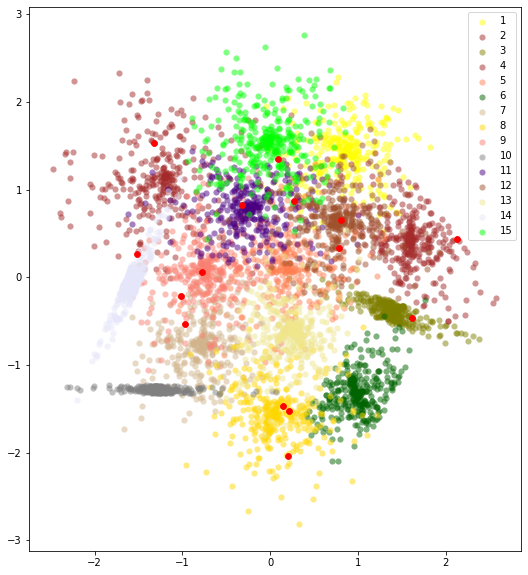

In [10]:
scatter_plot(X, centers_init, Y)

In [11]:
kmeans = KMeans(n_clusters = K, init = centers_init).fit(X)
labels = kmeans.predict(X)
centers_kmeans = kmeans.cluster_centers_
print("Centroids from sklearn.cluster.KMeans: \n", centers_kmeans)

Centroids from sklearn.cluster.KMeans: 
 [[ 0.03724336 -1.603407  ]
 [-1.29370993 -1.25749039]
 [ 1.59143103  0.45815279]
 [-1.55529948 -0.03678872]
 [-0.0268329   1.62044184]
 [ 0.22891549 -0.64079536]
 [ 0.95126481 -1.34349391]
 [-0.71338378 -0.79147841]
 [ 0.71911138  0.70903276]
 [-1.2875652   1.18372846]
 [-0.68044859  0.08016812]
 [ 0.26115772  0.1084118 ]
 [ 1.41911359 -0.38359183]
 [-0.26621702  0.8420092 ]
 [ 0.88749945  1.48617233]]


/Users/antonioruiz/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/cluster/_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


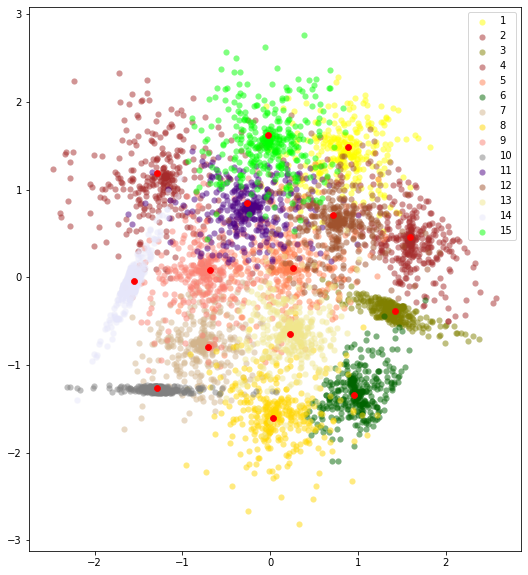

In [12]:
scatter_plot(X, centers_kmeans, Y)

In [13]:
# freeze parts of the NN that are not going to be trained
#freeze_module(NK.linear_in.weight)
NKmeans.linear_in.weight.requires_grad = False
freeze_module(NKmeans.linear_pool)
NKmeans.linear_in.bias.requires_grad = True

loss =  1.9461557436223955
loss =  1.6290532923821301
loss =  1.2754792294573676
loss =  1.0384740692913612
loss =  0.9487018998232073
loss =  0.8873323511906415
loss =  0.8764617883270891
loss =  0.8702232696779595
loss =  0.8695278133587763
loss =  0.8676879886800958
loss =  0.867218904293288
loss =  0.8675520802260928
loss =  0.8672844123267741


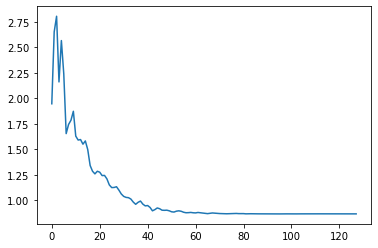

In [14]:
# use Adam optmizer
optimizer = optim.Adam(NKmeans.parameters(), lr = 1.0)
list_loss = []
num_epochs = 128
for epoch in range(num_epochs):
    for batch_idx, data_batch in enumerate(train_loader):
        #get the data and labels
        x, y =  data_batch
        #print(x.shape)
        x = x.to(device)
        optimizer.zero_grad()
        # run the model
        gk, Nk = NKmeans(x)
        # get the loss
        loss = loss_function(gk, Nk)
        #do gradient descent
        loss.backward()
        if epoch % 10 == 0:
            print("loss = ", loss.item())
        list_loss.append(loss.item())
        optimizer.step()

plt.plot(list_loss)

In [14]:
b_last = NKmeans.linear_in.bias.data
b_last = -1 * b_last.view(K, -1)
print("b = ", b_last)

b =  tensor([[ 1.2637,  1.0021],
        [-0.7351,  0.2685],
        [ 1.1721, -0.7370],
        [ 0.6395,  1.5610],
        [ 1.4069,  0.2185],
        [-1.4215, -0.6245],
        [-0.7961, -1.4128],
        [-0.4748, -0.3848],
        [-1.1056,  1.4974],
        [-1.5388,  0.2685],
        [ 0.4221, -0.4054],
        [ 0.3758,  0.3388],
        [-0.0278, -1.3525],
        [ 1.3788, -1.4296],
        [-0.3960,  1.2390]])


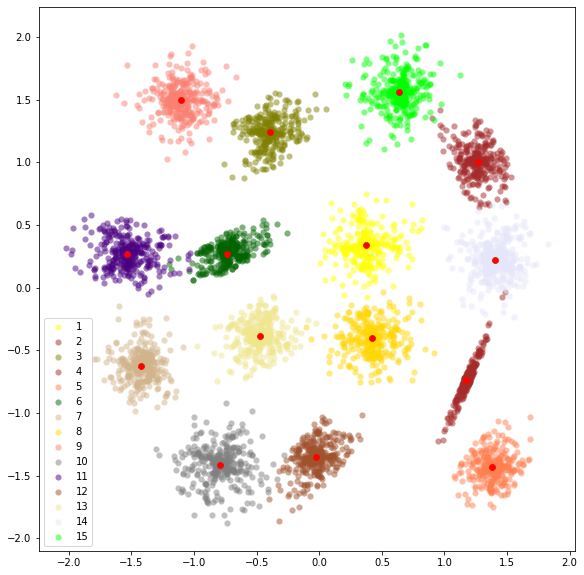

In [15]:
scatter_plot(X, b_last, Y)

In [22]:
K = 5
D = 3
linear_in_fixed = construct_linear_in_fixed(K, D)
#print(linear_in_fixed)
b_init = torch.zeros(K*D)
linear_pool_fixed = construct_linear_pool_fixed(K, D)
#print(linear_pool_fixed)
print("Shape of linear_in_fixed: ", linear_in_fixed.shape)
print("Shape of linear_pool_fixed: ", linear_pool_fixed.shape)
#print(b_init)
NK = NeuralKmeans(K, D, linear_in_fixed, linear_pool_fixed, b_init)
#print(NK.linear.weight)
x = torch.randint(1, 5, (3, D))
x = x.float()
print(x)
z = NK(x)

print(z)

Shape of linear_in_fixed:  torch.Size([15, 3])
Shape of linear_pool_fixed:  torch.Size([5, 15])
tensor([[4., 4., 4.],
        [1., 2., 3.],
        [2., 3., 1.]])
Initial shape:  torch.Size([3, 3])
Shape after in and quadratic layer:  torch.Size([3, 15])
Shape after linear pool layer:  torch.Size([3, 5])
idx =  tensor([[[0]],

        [[0]],

        [[0]]])
tensor([[[-48.]],

        [[-14.]],

        [[-14.]]], grad_fn=<SqueezeBackward1>)


In [22]:
class MyModule(nn.Module):
    def __init__(self, weights):
        super(MyModule, self).__init__()

        self.linear = nn.Linear(weights.shape[0], weights.shape[1])
        with torch.no_grad():
            self.linear.weight.copy_(weights)
        
    def forward(self, x):
        x = self.linear(x)
        return x

weights = torch.randn(15, 10)
model = MyModule(weights)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# out = model(torch.randn(1, 10))
# out.mean().backward()

# for name, param in model.named_parameters():
#     print(name, param.grad)

# w0 = model.linear.weight.clone()
# optimizer.step()

RuntimeError: The size of tensor a (15) must match the size of tensor b (10) at non-singleton dimension 1

In [32]:
a = 4 * torch.ones(3)
b = 2 * torch.ones(3)
c = a/b
print(a)
print(b)
print(c)

tensor([4., 4., 4.])
tensor([2., 2., 2.])
tensor([2., 2., 2.])


In [17]:
Nk, _ = np.histogram([1, 2, 1], bins = np.arange(3))
Nk = Nk.astype(float)
idx = np.where(Nk==0)
Nk[idx] = 1e-5
print(idx)
print(Nk)

(array([0]),)
[1.e-05 3.e+00]


In [42]:
print(5000/15)

333.3333333333333


In [15]:
samples = torch.Tensor([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

labels = torch.LongTensor([0, 1, 2, 0, 1, 2, 0, 1, 2])

unique_labels, labels_count = labels.unique(dim=0, return_counts=True)
print(unique_labels)
print(labels_count)
res = torch.zeros_like(unique_labels, dtype=torch.float).scatter_add_(0, labels, samples)
print(res)

tensor([0, 1, 2])
tensor([3, 3, 3])
tensor([1.2000, 1.5000, 1.8000])


In [16]:
samples += 1
print(samples)

tensor([1.1000, 1.2000, 1.3000, 1.4000, 1.5000, 1.6000, 1.7000, 1.8000, 1.9000])
